# Hidden Markov Models

Reference: https://en.wikipedia.org/wiki/Hidden_Markov_model

Hidden Markov Models (HMMs) are a class of probabilistic graphical model that allow us to predict a sequence of unknown (hidden) variables from a set of observed variables. 

An HMM is characterised by the following:
    \begin{itemize}
        \item $X$ - states in the model
        \item $y$ - the observations
        \item $A = \{a_{ij}\}$ - the state transition probabilities
        \item $B = \{b_j (k)\}$ - the observation probabilities
        \item $\pi$ - the initial state probabilities
    \end{itemize}

The following figure shows a diagram of the probabilistic parameters of an HMM.
<img src="img/hmm_diagram.png" width="500"/>

There are three fundamental problems regarding HMMs:
    \begin{itemize}
        \item \textbf{Problem 1 (Likelihood)} - given an HMM $\lambda = (A,B)$ and an observation sequence O, determine the likelihood $P(O|\lambda)$}  
        \item \textbf{Problem 2 (Decoding)} - given an HMM $\lambda = (A,B)$ and an observation sequence O, discover the best hidden state sequence
        \item \textbf{Problem 1 (Learning)} - given an observation sequence O and the set of states
in the HMM, learn the HMM parameters A and B
    \end{itemize}

Based on the type of the observations, we can differentiate between HMMs with discrete observations, HMMs with continuous observations or a combination of the two. Our implementation can deal with multinomial and Gaussian observations. 

In the followings we provide examples for each type, with explanations on how to use the code in each case. 

In [1]:
 # path settings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import pickle
from hmmlearn import hmm
from parse import compile
import seaborn as sns
import matplotlib.pyplot as plt

from src.GaussianHMM import GaussianHMM
from src.DiscreteHMM import MultinomialHMM
from src.HeterogeneousHMM import HeterogeneousHMM
import src.utils as su

%load_ext autoreload
%autoreload 2

# seaborn settings
sns.set(font_scale=1.25)
sns.set_style("whitegrid")

# Multinomial HMM

Consider the following example from https://web.stanford.edu/~jurafsky/slp3/A.pdf. (All the illustrative images are taken from that source.)

A climatologist in 2799 is studying the history of global warming. He cannot find any weather records from Baltimore, Maryland, for summer 2020, but he finds Jason's diary, where it's listed how many ice creams he ate each day of that summer. The goal is to estimate whether it was a hot or cold day based on these observations. The following figure shows a possible HMM representation of this problem.

<img src="img/discrete.png" width="600"/>

The two hidden states (H and C) correspond to hot and cold weather, and the observations O = {1,2,3} correspond to the number of ice creams eaten by Jason on a given day. 

## Setting up the model

The MultinomialHMM class uses the following arguments for initialisation:
    \begin{itemize}
        \item \textit{n_states} (int) - the number of hidden states
        \item \textit{n_emissions} (int) - the number of distinct observations
        \item \textit{n_features} (list) - a list containing the number of different symbols for each emission
        \item \textit{params} (string, optional) - controls which parameters are updated in the
            training process; defaults to all parameters
        \item \textit{init_params} (string, optional) - controls which parameters are initialised
            prior to training; defaults to all parameters
        \item \textit{init_type} (string, optional) - name of the initialisation
            method to use for initialising the model parameters before training
        \item \textit{pi_prior} (array, optional) - array of shape (n_states, ) setting the
            parameters of the Dirichlet prior distribution for 'pi'
        \item \textit{A_prior} (array, optional) - array of shape (n_states, n_states),
            giving the parameters of the Dirichlet prior distribution for each
            row of the transition probabilities 'A'
        \item \textit{learn_rate} (float, optional) - a value from the $[0,1)$ interval, controlling how much
            the past values of the model parameters count when computing the new
            model parameters during training; defaults to 0
        \item \textit{missing} (int or NaN, optional) - a value indicating what character indicates a missed
            observation in the observation sequences; defaults to NaN
        \item \textit{verbose} (bool, optional) - flag to be set to True if per-iteration
            convergence reports should be printed during training
    \end{itemize}

In [2]:
states = ["H", "C"]
observations = [[1, 2, 3]]

# instantiate a MultinomialHMM object
my_hmm = MultinomialHMM(
    # number of hidden states (H and C)
    n_states=2,     
    # number of discrete emissions (how many ice creams Jason ate)
    n_emissions=1,
    # length of the observation alphabet (O = {1, 2, 3}, which becomes {0, 1, 2})
    n_features=[3]
)

# we set model parameters according to the example
# the initial state probabilities, array of shape (n_states, )
my_hmm.pi = np.array([0.8, 0.2])
# the state transition probabilities, array of shape (n_states, n_states)
my_hmm.A = np.array([[0.6, 0.4], [0.5, 0.5]])
# the emission probabilities, array of shape (n_emissions, ) x (n_states, n_features_i) for i = 0, ... len(n_features)-1
my_hmm.B = np.array([[[0.2, 0.4, 0.4], [0.5, 0.4, 0.1]]])

su.pretty_print_hmm(my_hmm, states=states, emissions=observations)

Priors
+------------+------------+
|     H      |     C      |
+------------+------------+
| P(H)=0.800 | P(C)=0.200 |
+------------+------------+
Transitions
+---+--------------+--------------+
| _ |      H       |      C       |
+---+--------------+--------------+
| H | P(H|H)=0.600 | P(C|H)=0.400 |
| C | P(H|C)=0.500 | P(C|C)=0.500 |
+---+--------------+--------------+
Emissions
+---+--------------+--------------+--------------+
| _ |      1       |      2       |      3       |
+---+--------------+--------------+--------------+
| H | P(1|H)=0.200 | P(2|H)=0.400 | P(3|H)=0.400 |
| C | P(1|C)=0.500 | P(2|C)=0.400 | P(3|C)=0.100 |
+---+--------------+--------------+--------------+


## Problem 1

We want to determine the probability of an ice-cream observation sequence like 3 1 3, but we don’t know what the hidden state sequence is. In order to compute the likelihood, the \textit{forward} function of the model can be called. This takes as argument
   \begin{itemize}
        \item \textit{observation_sequence} (array) - an array of shape (n_samples, n_emissions) containing an observation sequence
   \end{itemize}
and returns:
    \begin{itemize}
        \item \textit{log_likelihood} (float) - log probability of the observation sequence
    \end{itemize}

In [3]:
# all the values from the given example are decreased by one, because the model uses 0 as the first possible observation symbol
observation_sequence = np.array([[2], [0], [2]])

# The returned value is the log of the probability, i.e: log P(O|model), so in order to get P(O|model) just compute the exp
print("P(3 1 3) = {:.4f}".format(np.exp(my_hmm.forward(observation_sequence))))

P(3 1 3) = 0.0286


## Problem 2

In the ice-cream domain, given a sequence of ice-cream observations 3 1 3 and an HMM, the task of the decoder is to find the best hidden weather sequence (H C H). 

For this task the most commonly used method is the Viterbi algorithm. We also implemented the MAP approach. The \textit{decode} function of the model can be called. This takes as arguments:
    \begin{itemize}
        \item \textit{observation_sequences} (list) - a list of arrays of shape (n_samples, n_emissions) containing one or more observation sequences of different lengths
        \item \textit{algorithm} (string, optional) - name of the decoder algorithm to use; can be "viterbi" or "map"; defaults to "viterbi".
    \end{itemize}
and returns:
    \begin{itemize}
        \item \textit{log_likelihood} (float) - log probability of the produced state sequence
        \item \textit{state_sequences} (list) - list of arrays containing labels for each
                    observation from observation_sequences obtained via the given
                    decoder algorithm
    \end{itemize}

In [4]:
logL, state_seq = my_hmm.decode([observation_sequence], algorithm="viterbi")
print("The Viterbi state sequence: {}. logL = {:.4f}".format([states[si] for si in state_seq[0]], logL))

logL, state_seq = my_hmm.decode([observation_sequence], algorithm="map")
print("The MAP state sequence: {}. logL = {:.4f}".format([states[si] for si in state_seq[0]], logL))

The Viterbi state sequence: ['H', 'C', 'H']. logL = 0.0128
The MAP state sequence: ['H', 'C', 'H']. logL = 2.3632


## Problem 3

For this task, we first generate some observation sequences from the model, after we will create a model, in which the parameters are initialised randomly and try to learn the generator's parameters from the observation sequences. For the training process the Baum-Welch algorithm is implemented. 

Initialisation 1
iter: 0, log_likelihood = -2636.0477839797263, delta = nan
iter: 1, log_likelihood = -2434.9265060986368, delta = 201.12127788108955
iter: 2, log_likelihood = -2434.917240318855, delta = 0.00926577978179921
iter: 3, log_likelihood = -2434.908624941005, delta = 0.008615377849764627
iter: 4, log_likelihood = -2434.9005904859227, delta = 0.008034455082452041
iter: 5, log_likelihood = -2434.893078870206, delta = 0.00751161571679404
iter: 6, log_likelihood = -2434.886040939766, delta = 0.00703793043976475
Converged -> iter: 6, log_likelihood = -2434.886040939766


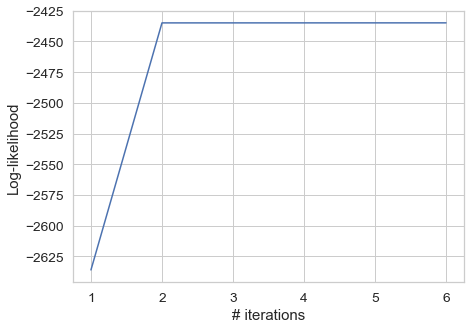

In [5]:
# generate observation sequences of different lengths
lengths = np.random.randint(25, 150, size=25)
X = [
    my_hmm.sample(n_sequences=1, n_samples=n_samples)[0][0] for n_samples in lengths
]

# instantiate a MultinomialHMM object
trained_hmm = MultinomialHMM(
    # number of hidden states (H and C)
    n_states=2,     
    # number of discrete emissions (how many ice creams Jason ate)
    n_emissions=1,
    # length of the observation alphabet (O = {1, 2, 3}, which becomes {0, 1, 2})
    n_features=[3],
    # prior for the start probabilities
    pi_prior=np.array([5, 1]),
    init_type="random",
    verbose=True
)

# reinitialise the parameters and see if we can re-learn them
trained_hmm, log_likelihoods = trained_hmm.train(
    X,
    n_init=1,     # no. of initialisations - we only do it once this time; if multiple initialisations are used, the model with the best log-likelihood will be returned
    n_iter=100,   # maximum no. of iterations to use
    thres=1e-04,   # convergence threshold (in this case if the change in consecutive log-likelihood is < 0.1%)
    conv_iter=5,  # no. of iterations for which the convergence criteria should hold before stopping
    plot_log_likelihood=True, # if we want a plot of the log-likelihood evolution over the iterations
)

Now if we look at the model parameters, we can see that using only 25 sequences of  25 - 150 samples leads to a quite accurate estimation of the parameters of the generator HMM. (Note that the order of states is swapped).

In [6]:
su.pretty_print_hmm(my_hmm, states=states, emissions=observations)

Priors
+------------+------------+
|     H      |     C      |
+------------+------------+
| P(H)=0.800 | P(C)=0.200 |
+------------+------------+
Transitions
+---+--------------+--------------+
| _ |      H       |      C       |
+---+--------------+--------------+
| H | P(H|H)=0.600 | P(C|H)=0.400 |
| C | P(H|C)=0.500 | P(C|C)=0.500 |
+---+--------------+--------------+
Emissions
+---+--------------+--------------+--------------+
| _ |      1       |      2       |      3       |
+---+--------------+--------------+--------------+
| H | P(1|H)=0.200 | P(2|H)=0.400 | P(3|H)=0.400 |
| C | P(1|C)=0.500 | P(2|C)=0.400 | P(3|C)=0.100 |
+---+--------------+--------------+--------------+


# Gaussian HMM

Source of example: https://hmmlearn.readthedocs.io/en/0.2.0/auto_examples/plot_hmm_sampling.html#sphx-glr-auto-examples-plot-hmm-sampling-py. 

Consider an HMM with Gaussian emissions, 4 hidden states with specified mean and covariance. The following figure shows shows some samples drawn from the model with the corresponding transitions. 

<img src="img/gauss_hmm_samples.png" width="600"/>

## Setting up the model

The GaussianHMM class uses the following arguments for initialisation:
\begin{itemize}
    \item \textit{n_states} (int) - the number of hidden states
    \item \textit{n_emissions} (int) - the number of distinct Gaussian observations
    \item \textit{params} (string, optional) - controls which parameters are updated in the training process; defaults to all parameters
    \item \textit{init_params} (string, optional) - controls which parameters are initialised prior to training; defaults to all parameters
    \item \textit{init_type} (string, optional) - name of the initialisation method to use for initialising the model parameters before training; can be "random" or "kmeans"
    \item \textit{covariance_type} (string, optional) - string describing the type of covariance parameters to use.  Must be one of: "diagonal", "full", "spherical" or "tied"; defaults to "diagonal"
    \item \textit{pi_prior} (array, optional) - array of shape (n_states, ) setting the parameters of the Dirichlet prior distribution for 'pi'
    \item \textit{A_prior} (array, optional) - array of shape (n_states, n_states), giving the parameters of the Dirichlet prior distribution for each row of the transition probabilities 'A'
    \item \textit{means_prior, means_weight} (array, optional) - arrays of shape (n_states, 1) providing the mean and precision of the Normal prior distribution for the means
    \item \textit{covars_prior, covars_weight} (array, optional) - shape (n_states, 1), provides the parameters of the prior distribution for the covariance matrix
    \item \textit{min_covar} (float, optional)- floor on the diagonal of the covariance matrix to prevent overfitting. Defaults to 1e-3.
    \item \textit{learn_rate} (float, optional) - a value from the $[0,1)$ interval, controlling how much the past values of the model parameters count when computing the new model parameters during training; defaults to 0
    \item \textit{verbose} (bool, optional) - flag to be set to True if per-iteration convergence reports should be printed during training
\end{itemize}

In [7]:
# instantiate a MultinomialHMM object
my_hmm = GaussianHMM(
    n_states=4,
    n_emissions=2,
    covariance_type="diagonal"
)

# we set model parameters according to the example
# the initial state probabilities, array of shape (n_states, )
my_hmm.pi = np.array([0.6, 0.3, 0.1, 0.0])
# the state transition probabilities, array of shape (n_states, n_states)
my_hmm.A = np.array(
    [
        [0.7, 0.2, 0.0, 0.1],
        [0.3, 0.5, 0.2, 0.0],
        [0.0, 0.3, 0.5, 0.2],
        [0.2, 0.0, 0.2, 0.6],
    ]
)
# the means of each component
my_hmm.means = np.array([[0.0, 0.0], [0.0, 11.0], [9.0, 10.0], [11.0, -1.0]])

# the covariance of each component - shape depends `covariance_type`
#             (n_states, )                          if "spherical",
#             (n_states, n_emissions)               if "diagonal",
#             (n_states, n_emissions, n_emissions)  if "full"
#             (n_emissions, n_emissions)            if "tied"
my_hmm.covars = 0.5 * np.ones((4, 2))  # diagonal covariance matrix

su.pretty_print_hmm(my_hmm, hmm_type="Gaussian")

Priors
+--------------+--------------+--------------+--------------+
|     S_0      |     S_1      |     S_2      |     S_3      |
+--------------+--------------+--------------+--------------+
| P(S_0)=0.600 | P(S_1)=0.300 | P(S_2)=0.100 | P(S_3)=0.000 |
+--------------+--------------+--------------+--------------+
Transitions
+-----+------------------+------------------+------------------+------------------+
|  _  |       S_0        |       S_1        |       S_2        |       S_3        |
+-----+------------------+------------------+------------------+------------------+
| S_0 | P(S_0|S_0)=0.700 | P(S_1|S_0)=0.200 | P(S_2|S_0)=0.000 | P(S_3|S_0)=0.100 |
| S_1 | P(S_0|S_1)=0.300 | P(S_1|S_1)=0.500 | P(S_2|S_1)=0.200 | P(S_3|S_1)=0.000 |
| S_2 | P(S_0|S_2)=0.000 | P(S_1|S_2)=0.300 | P(S_2|S_2)=0.500 | P(S_3|S_2)=0.200 |
| S_3 | P(S_0|S_3)=0.200 | P(S_1|S_3)=0.000 | P(S_2|S_3)=0.200 | P(S_3|S_3)=0.600 |
+-----+------------------+------------------+------------------+------------------+

## Problem 3

For this task, similarly like in the discrete HMM case, we first generate some observation sequences from the model, after we will create a model, in which the parameters are initialised randomly and try to learn the generator's parameters from the observation sequences.

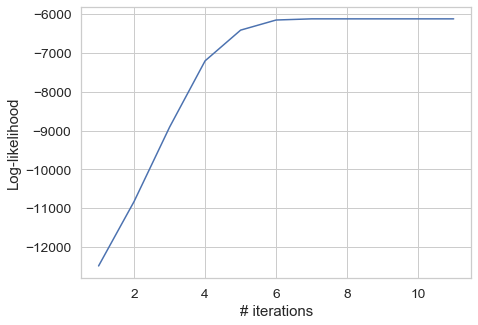

In [8]:
# generate observation sequences of different lengths
lengths = np.random.randint(25, 150, size=25)
X = [
    my_hmm.sample(n_sequences=1, n_samples=n_samples)[0][0] for n_samples in lengths
]

# instantiate a MultinomialHMM object
trained_hmm = GaussianHMM(
    # number of hidden states
    n_states=4,
    # number of distinct emissions
    n_emissions=2,
    # initialisation type can be "random", "kmeans"
    init_type="kmeans",
    # can be "diagonal", "full", "spherical", "tied"
    covariance_type="diagonal",
    verbose=False
)

# reinitialise the parameters and see if we can re-learn them
trained_hmm, log_likelihoods = trained_hmm.train(
    X,
    n_init=1,     # number of initialisations to perform
    n_iter=100,   # maximum number of iterations to run
    thres=0.001,  # what percentage of change in the log-likelihood between iterations is considered convergence
    conv_iter=5,  # for how many iterations does it have to hold
    # whether to plot the evolution of the log-likelihood over the iterations
    plot_log_likelihood=True,
    # set to True if want to train until maximum number of iterations is reached
    ignore_conv_crit=False,
    no_init=False,  # set to True if the model parameters shouldn't be re-initialised befor training; in this case they have to be set manually first, otherwise errors occur
)

Now if we look at the model parameters, we can see that using only 25 sequences of  25 - 150 samples leads to a quite accurate estimation of the parameters of the generator HMM. (Note that the order of states is swapped).

In [9]:
su.pretty_print_hmm(trained_hmm, hmm_type="Gaussian")

Priors
+--------------+--------------+--------------+--------------+
|     S_0      |     S_1      |     S_2      |     S_3      |
+--------------+--------------+--------------+--------------+
| P(S_0)=0.000 | P(S_1)=0.640 | P(S_2)=0.320 | P(S_3)=0.040 |
+--------------+--------------+--------------+--------------+
Transitions
+-----+------------------+------------------+------------------+------------------+
|  _  |       S_0        |       S_1        |       S_2        |       S_3        |
+-----+------------------+------------------+------------------+------------------+
| S_0 | P(S_0|S_0)=0.517 | P(S_1|S_0)=0.221 | P(S_2|S_0)=0.057 | P(S_3|S_0)=0.205 |
| S_1 | P(S_0|S_1)=0.104 | P(S_1|S_1)=0.677 | P(S_2|S_1)=0.191 | P(S_3|S_1)=0.028 |
| S_2 | P(S_0|S_2)=0.043 | P(S_1|S_2)=0.282 | P(S_2|S_2)=0.440 | P(S_3|S_2)=0.235 |
| S_3 | P(S_0|S_3)=0.220 | P(S_1|S_3)=0.057 | P(S_2|S_3)=0.297 | P(S_3|S_3)=0.426 |
+-----+------------------+------------------+------------------+------------------+

# HMM with labels

## Loading the training data

TODO: explain the data

<img src="img/heterogeneous_samples.png" width="600"/>

In [10]:
# load the training data - train.pickle contains a dataframe of 10 time series sequences of 286 - 289 observations
# and the preprocessed training sequence list as well
with open("data/train.pickle", "rb") as f:
    temp = pickle.load(f)
    df = temp["all"]
    training_seq = temp["tr_seq"]
    
df.head()

,seq_no,date,actigraphy,light,app_usage,sleep
0,0,2018-08-05 15:05:30,-0.305134,-0.918191,1,0
1,0,2018-08-05 15:10:32,-0.290736,NaN,1,0
2,0,2018-08-05 15:15:32,-0.595398,NaN,1,0
3,0,2018-08-05 15:20:34,-0.545724,NaN,1,0
4,0,2018-08-05 15:25:34,0.033796,NaN,1,0


## Training the model

The HeterogeneousHMM class uses the following arguments for initialisation:
\begin{itemize}
    \item \textit{n_states} (int) - the number of hidden states
    \item \textit{n_g_emissions} (int) - the number of distinct Gaussian observations
    \item \textit{n_d_emissions} (int) - the number of distinct discrete observations
    \item \textit{n_d_features} (list - list of the number of possible observable symbols for each discrete emission 
    \item \textit{params} (string, optional) - controls which parameters are updated in the training process; defaults to all parameters
    \item \textit{init_params} (string, optional) - controls which parameters are initialised prior to training; defaults to all parameters
    \item \textit{init_type} (string, optional) - name of the initialisation method to use for initialising the model parameters before training; can be "random" or "kmeans"
    \item \textit{nr_no_train_de} (int) - this number indicates the number of discrete emissions whose Matrix Emission Probabilities are fixed and are not trained; it is important to to order the observed variables such that the ones whose emissions aren't trained are the last ones 
    \item \textit{covariance_type} (string, optional) - string describing the type of covariance parameters to use.  Must be one of: "diagonal", "full", "spherical" or "tied"; defaults to "diagonal"
    \item \textit{pi_prior} (array, optional) - array of shape (n_states, ) setting the parameters of the Dirichlet prior distribution for 'pi'
    \item \textit{A_prior} (array, optional) - array of shape (n_states, n_states), giving the parameters of the Dirichlet prior distribution for each row of the transition probabilities 'A'
    \item \textit{means_prior, means_weight} (array, optional) - arrays of shape (n_states, 1) providing the mean and precision of the Normal prior distribution for the means
    \item \textit{covars_prior, covars_weight} (array, optional) - shape (n_states, 1), provides the parameters of the prior distribution for the covariance matrix
    \item \textit{min_covar} (float, optional)- floor on the diagonal of the covariance matrix to prevent overfitting. Defaults to 1e-3.
    \item \textit{learn_rate} (float, optional) - a value from the $[0,1)$ interval, controlling how much the past values of the model parameters count when computing the new model parameters during training; defaults to 0
    \item \textit{verbose} (bool, optional) - flag to be set to True if per-iteration convergence reports should be printed during training
\end{itemize}

Initialisation 1
iter: 0, log_likelihood = -10626.2375554891, delta = nan
iter: 1, log_likelihood = -5415.839683894325, delta = 5210.397871594775
iter: 2, log_likelihood = -433.16551658378637, delta = 4982.674167310539
iter: 3, log_likelihood = 522.1705058553455, delta = 955.3360224391319
iter: 4, log_likelihood = 564.192545434962, delta = 42.02203957961649
iter: 5, log_likelihood = 585.457567119079, delta = 21.265021684117073
iter: 6, log_likelihood = 602.6693220274055, delta = 17.211754908326498
iter: 7, log_likelihood = 613.9525929373856, delta = 11.283270909980047
iter: 8, log_likelihood = 621.1872942197575, delta = 7.23470128237193
iter: 9, log_likelihood = 625.9986199044715, delta = 4.8113256847140065
iter: 10, log_likelihood = 629.0988998364218, delta = 3.10027993195024
iter: 11, log_likelihood = 631.079418095725, delta = 1.9805182593032669
iter: 12, log_likelihood = 632.3572042331059, delta = 1.2777861373808719
iter: 13, log_likelihood = 633.1939375870386, delta = 0.83673335393

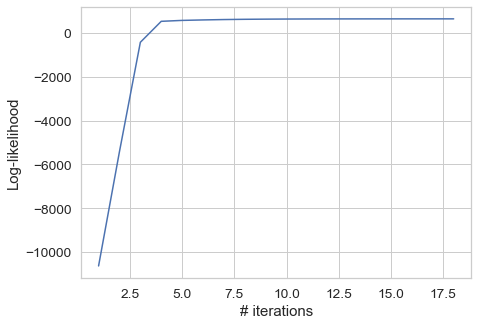

Priors
+--------------+--------------+
|     S_0      |     S_1      |
+--------------+--------------+
| P(S_0)=0.501 | P(S_1)=0.499 |
+--------------+--------------+
Transitions
+-----+------------------+------------------+
|  _  |       S_0        |       S_1        |
+-----+------------------+------------------+
| S_0 | P(S_0|S_0)=0.784 | P(S_1|S_0)=0.216 |
| S_1 | P(S_0|S_1)=0.182 | P(S_1|S_1)=0.818 |
+-----+------------------+------------------+
Means
+-----+--------+--------+
|  _  |  GE_0  |  GE_1  |
+-----+--------+--------+
| S_0 | 0.431  | -0.001 |
| S_1 | -0.360 | 0.023  |
+-----+--------+--------+
Covariances
S_0
+------+-------+-------+
|  _   |  GE_0 |  GE_1 |
+------+-------+-------+
| GE_0 | 1.596 | 0.000 |
| GE_1 | 0.000 | 0.251 |
+------+-------+-------+
S_1
+------+-------+-------+
|  _   |  GE_0 |  GE_1 |
+------+-------+-------+
| GE_0 | 0.219 | 0.000 |
| GE_1 | 0.000 | 0.000 |
+------+-------+-------+
Emissions
+-----+--------------------+--------------------+
|  

In [11]:
# instantiate a HeterogeneousHMM object
my_hmm = HeterogeneousHMM(
        n_states=2,
        n_g_emissions=2,
        n_d_emissions=2,
        n_d_features=[2, 2],
        init_type="random",
        covariance_type="diagonal",
        nr_no_train_de=2,
        state_no_train_de=1,
        verbose=True,
    )

# we want to fix the emission probabilities for the sleep parameter, so we need to manually initialise the 
# B matrix before the fitting; so for the first emissions, since we have no prior knowledge on it, we uniformly
# initialise the emission probablities, and for the second one we set it to the desired value
my_hmm.B = [np.asarray([[0.5, 0.5], [1, 0]]), np.asarray([[0.5, 0.5], [0.2, 0.8]])]

# train the model to estimate the parameters
my_hmm, log_likelihood = my_hmm.train(
    training_seq, n_init=1, n_iter=50, thres=0.001, conv_iter=5, plot_log_likelihood=True,
)

# print model parameters
su.pretty_print_hmm(my_hmm, hmm_type="Heterogeneous")

## Sequence decoding

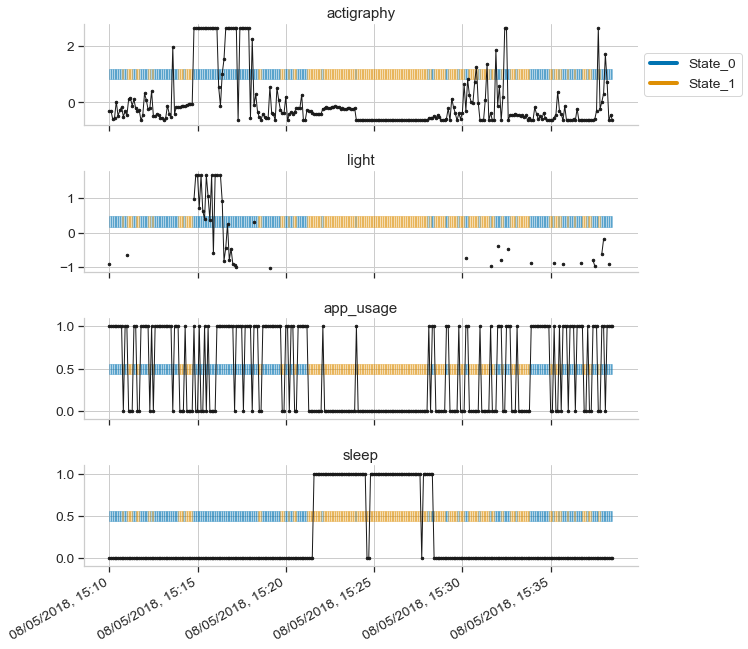

In [12]:
# decode a training sequences
logL, state_seq = my_hmm.decode([training_seq[0]], algorithm="viterbi")

su.plot_decode(training_seq[0], ["actigraphy", "light", "app_usage", "sleep"], state_seq[0], discrete_columns=["app_usage", "sleep"],
                time_stamps=df[df["seq_no"] == 0]["date"],figsize=(10, 10))
               